In [97]:
import kirra_libs as LIBS
import os, mpld3, nltk
import numpy as np
import pandas as pd
import fnmatch
os.chdir(".")
SOURCE_DATA_FILE = "data"

In [27]:
# get all file ".txt" in folder data
df = pd.DataFrame(columns=['title', 'desc'])
listfile = []
for dirpath, dirs, files in os.walk(SOURCE_DATA_FILE):
    for filename in fnmatch.filter(files, '*.txt'):
        listfile.append(dirpath+"/"+filename)
listfile[:10] #print 10 filename

['data/tempo/010210/010210-115.txt',
 'data/tempo/010210/010210-1132.txt',
 'data/tempo/010210/010210-1134.txt',
 'data/tempo/010210/010210-1124.txt',
 'data/tempo/010210/010210-1130.txt',
 'data/tempo/010210/010210-1136.txt',
 'data/tempo/010210/010210-1116.txt',
 'data/tempo/010210/010210-1133.txt',
 'data/tempo/010210/010210-1110.txt',
 'data/tempo/010210/010210-111.txt']

In [37]:
inc = 0
for filename in listfile[:10]:
    data = open("{}".format(filename), "r").readlines()
    try:  
        title = data[0].strip()
        desc = " ".join(data[1:]).strip().replace("\n","")
        #replace multiple space
        desc = ' '.join(desc.split())
        df.loc[inc] = [title, desc]
        inc += 1
    except:
        pass
df

,title,desc
0,Akri Patrio Masuk Ruang Isolasi RS Pertamina,"Akibat tersembur api saat syuting, anggota tri..."
1,Bambang Kesowo Bantah Telepon Taufik,Menteri Sekretaris Negara/Menseskab Bambang Ke...
2,Yusril Datang ke LP Cipinang,Menteri Kehakiman dan Hak Asasi Manusia Yusril...
3,Penyelidikan Pelanggaran HAM Tidak Terkait den...,Kepala Staf Angkatan Darat (KSAD) Jendral TNI ...
4,200 Ribu Gula Impor Salahi Izin,Dirjen Bea dan Cukai Kantor Wilayah IV Jakarta...
5,Korban Tewas di Cipinang Satu Orang,"Korban tewas akibat kerusuhan di LP Cipinang, ..."
6,Warga PDI-P agar Bersikap Anti Kekerasan,Ketua Umum PDI-P Megawati Soekarnoputri mengin...
7,Puluhan Senjata Tajam Disita di Cipinang,Aparat kepolisian menemukan puluhan senjata ta...
8,Indeks Melemah di Sesi I,Indeks harga saham gabungan (IHSG) melemah cuk...
9,"Eko dan Akri Patrio Terbakar, Masuk Rumah Sakit","Eko dan Akri, dua anggota kelompok komedi Patr..."


In [43]:
df['title'].values
# df['desc'].values[:10]

array(['Akri Patrio Masuk Ruang Isolasi RS Pertamina',
       'Bambang Kesowo Bantah Telepon Taufik',
       'Yusril Datang ke LP Cipinang',
       'Penyelidikan Pelanggaran HAM Tidak Terkait dengan Bantuan AS',
       '200 Ribu Gula Impor Salahi Izin',
       'Korban Tewas di Cipinang Satu Orang',
       'Warga PDI-P agar Bersikap Anti Kekerasan',
       'Puluhan Senjata Tajam Disita di Cipinang',
       'Indeks Melemah di Sesi I',
       'Eko dan Akri Patrio Terbakar, Masuk Rumah Sakit'], dtype=object)

In [47]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
dataarticle = list(df['desc'].values)
count = 0
for i in dataarticle:
    print("\rArticle process: {} from {}".format(count, len(dataarticle)))
    count += 1
    allwords_stemmed = LIBS.tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = LIBS.tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
print
print "total vacab stem: ",len(totalvocab_stemmed)
print "total vacab tokenize: ",len(totalvocab_tokenized)

Article process: 0 from 10
Article process: 1 from 10
Article process: 2 from 10
Article process: 3 from 10
Article process: 4 from 10
Article process: 5 from 10
Article process: 6 from 10
Article process: 7 from 10
Article process: 8 from 10
Article process: 9 from 10

total vacab stem:  2206
total vacab tokenize:  2206


In [52]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
vocab_frame[:10] #print 10 word


there are 2206 items in vocab_frame


,words
akibat,akibat
sembur,tersembur
api,api
saat,saat
syuting,syuting
",",","
anggota,anggota
trio,trio
komedi,komedi
patrio,patrio


In [63]:
from spacy.lang.id import stop_words
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer

STWRD = list(set(punctuation))
STWRD += list(set(digits))
STWRD += stop_words.STOP_WORDS

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=2, stop_words=STWRD,
                                 use_idf=True, tokenizer=LIBS.tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(list(df['desc'].values)) #fit the vectorizer to synopses

print("TF-idf matrix: ",tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 136 ms
('TF-idf matrix: ', (10, 125))


In [65]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print dist


[[ 1.11022302e-16  9.59898751e-01  9.67454031e-01  8.99155918e-01
   8.89903679e-01  8.92240994e-01  9.19411553e-01  9.25157928e-01
   9.81058030e-01  2.54661978e-01]
 [ 9.59898751e-01  0.00000000e+00  8.56466184e-01  8.59868727e-01
   9.59566361e-01  9.41591830e-01  6.34839799e-01  9.69164965e-01
   9.90529160e-01  9.89194082e-01]
 [ 9.67454031e-01  8.56466184e-01 -2.22044605e-16  7.60349012e-01
   9.39280762e-01  4.22067961e-01  8.98040619e-01  5.29561204e-01
   9.83497258e-01  9.37259354e-01]
 [ 8.99155918e-01  8.59868727e-01  7.60349012e-01 -8.88178420e-16
   8.60699527e-01  8.81602682e-01  7.56874286e-01  1.00000000e+00
   9.41391478e-01  9.29988859e-01]
 [ 8.89903679e-01  9.59566361e-01  9.39280762e-01  8.60699527e-01
   1.11022302e-16  9.22588780e-01  9.25775986e-01  8.82390960e-01
   7.46337883e-01  9.48703131e-01]
 [ 8.92240994e-01  9.41591830e-01  4.22067961e-01  8.81602682e-01
   9.22588780e-01  0.00000000e+00  8.08864060e-01  5.71174355e-01
   9.78960583e-01  8.49956306e-0

In [66]:
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 30.9 ms


In [68]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

# joblib.dump(km,  'rep_23072018.pkl')
# 
km = joblib.load('rep_23072018.pkl')
clusters = km.labels_.tolist()

In [71]:
films = { 'title': list(df['title'].values), 'synopsis': list(df['desc'].values), 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster'])
frame

,title,cluster
2,Akri Patrio Masuk Ruang Isolasi RS Pertamina,2
3,Bambang Kesowo Bantah Telepon Taufik,3
1,Yusril Datang ke LP Cipinang,1
3,Penyelidikan Pelanggaran HAM Tidak Terkait den...,3
0,200 Ribu Gula Impor Salahi Izin,0
1,Korban Tewas di Cipinang Satu Orang,1
3,Warga PDI-P agar Bersikap Anti Kekerasan,3
1,Puluhan Senjata Tajam Disita di Cipinang,1
0,Indeks Melemah di Sesi I,0
2,"Eko dan Akri Patrio Terbakar, Masuk Rumah Sakit",2


In [72]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

3    3
1    3
2    2
0    2
Name: cluster, dtype: int64

In [74]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: persen, berusaha, internasional, milik, ribu, 200,

Cluster 0 titles: 200 Ribu Gula Impor Salahi Izin, Indeks Melemah di Sesi I,

Cluster 1 words: lp, seorang, cipinang, lp, kerusuhan, tempo,

Cluster 1 titles: Yusril Datang ke LP Cipinang, Korban Tewas di Cipinang Satu Orang, Puluhan Senjata Tajam Disita di Cipinang,

Cluster 2 words: eko, akri, api, obor, patrio, kecelakaan,

Cluster 2 titles: Akri Patrio Masuk Ruang Isolasi RS Pertamina, Eko dan Akri Patrio Terbakar, Masuk Rumah Sakit,

Cluster 3 words: megawati, bersikap, pelanggaran, salah, presiden, laporan,

Cluster 3 titles: Bambang Kesowo Bantah Telepon Taufik, Penyelidikan Pelanggaran HAM Tidak Terkait dengan Bantuan AS, Warga PDI-P agar Bersikap Anti Kekerasan,





/home/notula/PycharmProjects/clustering/env/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/home/notula/PycharmProjects/clustering/env/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [75]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [76]:
#set up colors per clusters using a dict
cluster_colors = {0: '#e6194b', 1: '#3cb44b', 2: '#ffe119', 3: '#0082c8', 4: '#f58231', 5: '#911eb4', 6: '#46f0f0', 7: '#f032e6', 8: '#d2f53c', 9: '#fabebe',
                  10: '#008080', 11: '#e6beff', 12: '#aa6e28', 13: '#fffac8', 14: '#800000', 
                  15: '#aaffc3', 16: '#808000', 17: '#ffd8b1', 18: '#000080', 19: '#808080'}

#set up cluster names using a dict
cluster_names = {0: 'Family', 
                 1: 'Police', 
                 2: 'Father', 
                 3: 'Dance', 
                 4: 'Killed',
                 5: 'Family', 
                 6: 'Police', 
                 7: 'Father', 
                 8: 'Dance', 
                 9: 'Killed',
                 10: 'Family', 
                 11: 'Police', 
                 12: 'Father', 
                 13: 'Dance', 
                 14: 'Killed',
                 15: 'Family', 
                 16: 'Police', 
                 17: 'Father', 
                 18: 'Dance', 
                 19: 'Killed'}

/home/notula/PycharmProjects/clustering/env/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/notula/PycharmProjects/clustering/env/lib/python2.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


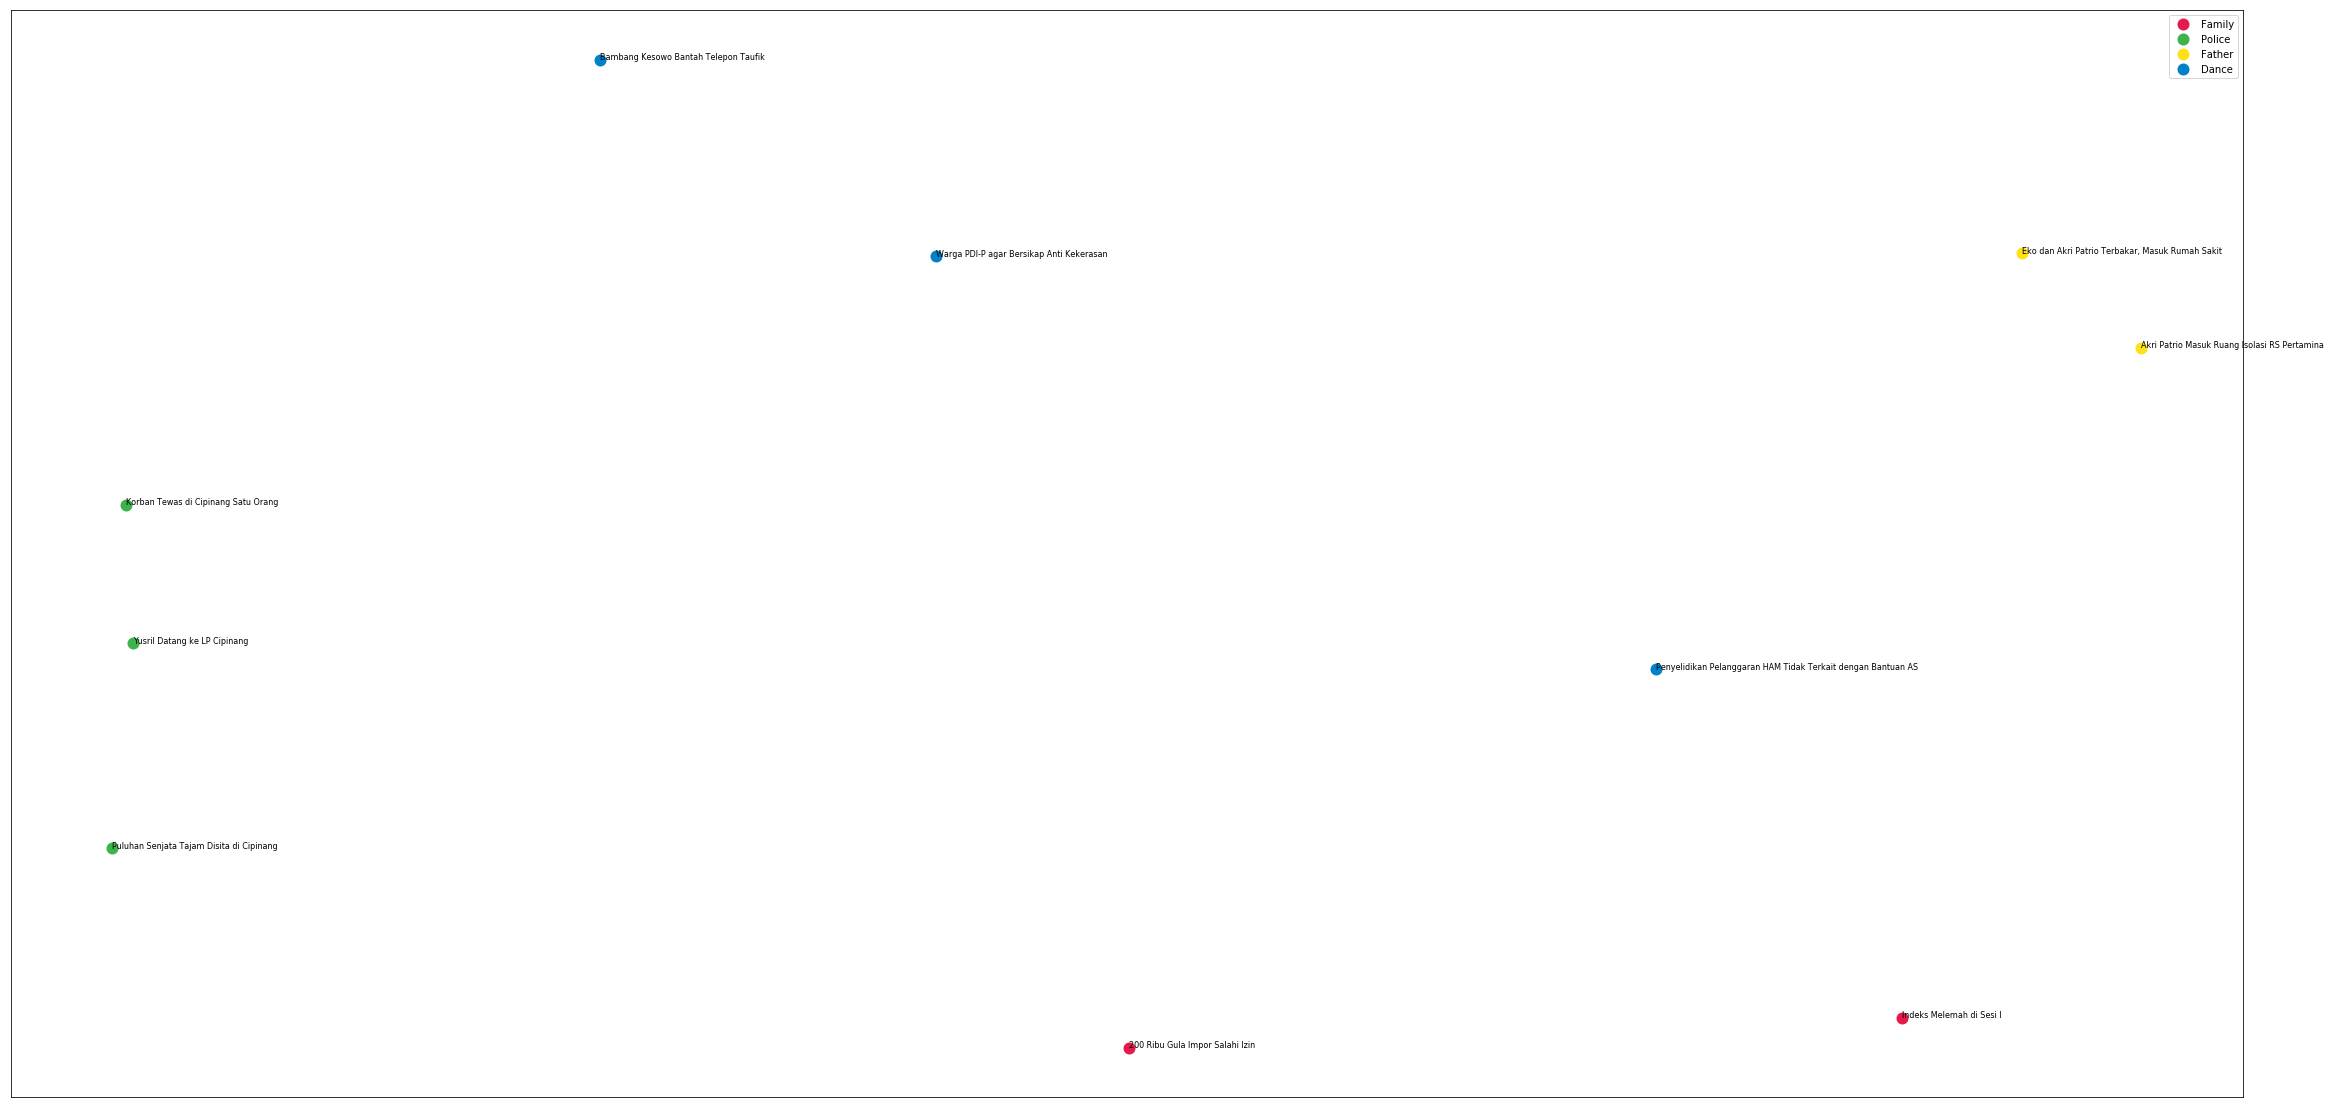

In [77]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 
# import mpld3
# mpld3.enable_notebook()

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(df['title'].values))) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(40, 20)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot|
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
# plt.savefig('clusters_small_noaxes.png', dpi=200)

In [78]:
plt.close()

In [81]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [82]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(df['title'].values))) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

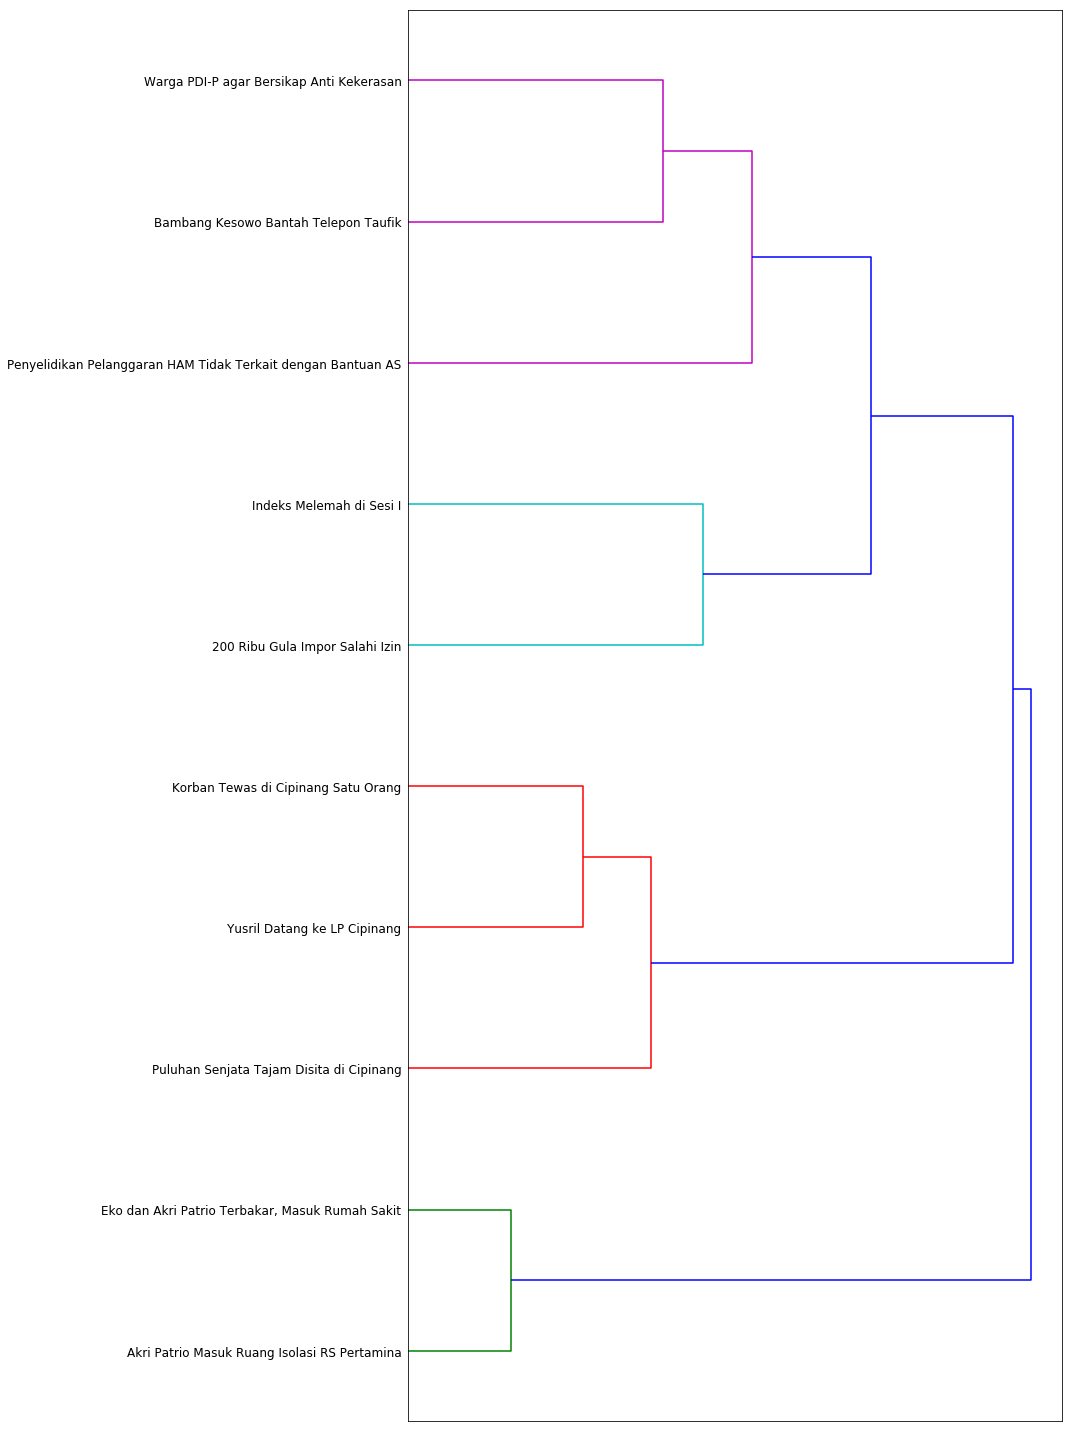

In [83]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list(df['title'].values));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [84]:

#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [85]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [114]:
   
dataarticle1 = []
for x in dataarticle:
    dataarticle1.append(x)
dataarticle1

TypeError: an integer is required

In [91]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in dataarticle]

#tokenize
%time tokenized_text = [LIBS.tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in STWRD] for text in tokenized_text]

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 25.5 ms
CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 88.7 ms
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.9 ms


In [92]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [94]:
%time lda = models.LdaModel(corpus, num_topics=5,  id2word=dictionary,  update_every=5,  chunksize=10000,  passes=100)

CPU times: user 416 ms, sys: 0 ns, total: 416 ms
Wall time: 419 ms


In [95]:
lda.show_topics()

[(0,
  u'0.042*"usaha" + 0.025*"putus" + 0.019*"sikap" + 0.019*"gula" + 0.019*"fasilitas" + 0.019*"ton" + 0.019*"menelpon" + 0.019*"baca" + 0.013*"temu" + 0.013*"wartawan"'),
 (1,
  u'0.021*"obor" + 0.021*"api" + 0.016*"kena" + 0.016*"parah" + 0.011*"ruang" + 0.011*"luka" + 0.011*"anggota" + 0.011*"syuting" + 0.011*"langsung" + 0.011*"kanannya"'),
 (2,
  u'0.070*"saham" + 0.031*"persen" + 0.028*"miliar" + 0.028*"melemah" + 0.024*"posisi" + 0.024*"nilai" + 0.020*"lot" + 0.020*"diikuti" + 0.020*"kuat" + 0.016*"top"'),
 (3,
  u'0.036*"orang" + 0.023*"salah" + 0.023*"bantu" + 0.018*"langgar" + 0.018*"dana" + 0.014*"ribu" + 0.014*"rusuh" + 0.010*"sanksi" + 0.010*"dijatuhi" + 0.010*"bukti"'),
 (4,
  u'0.025*"bangsa" + 0.017*"buka" + 0.017*"tindak" + 0.017*"citra" + 0.017*"teror" + 0.009*"akibat" + 0.009*"sweeping" + 0.009*"giat" + 0.009*"hukum" + 0.009*"milik"')]

In [108]:
# topics_matrix

In [109]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix
# topics_matrix = np.array(topics_matrix, dtype=object)

# topic_words = topics_matrix[:,:,1]
# for i in topic_words:
#     print([str(word) for word in i])
#     print()

[(0,
  [(u'usaha', 0.042008866),
   (u'putus', 0.024503924),
   (u'sikap', 0.018670376),
   (u'ton', 0.018669663),
   (u'gula', 0.018669663),
   (u'fasilitas', 0.018669663),
   (u'baca', 0.01866966),
   (u'menelpon', 0.01866966),
   (u'temu', 0.012838622),
   (u'wartawan', 0.012836645),
   (u'lapor', 0.012835995),
   (u'telepon', 0.012835566),
   (u'diimpor', 0.012835389),
   (u'impor', 0.012835389),
   (u'jual', 0.012835389),
   (u'pasar', 0.012835389),
   (u'ribu', 0.012835022),
   (u'persen', 0.012832889),
   (u'hadap', 0.0070024393),
   (u'keluarga', 0.007002424)]),
 (1,
  [(u'api', 0.020753115),
   (u'obor', 0.020753115),
   (u'kena', 0.015810682),
   (u'parah', 0.015809964),
   (u'ruang', 0.010872561),
   (u'luka', 0.010871426),
   (u'anggota', 0.01087045),
   (u'syuting', 0.010870114),
   (u'langsung', 0.010870026),
   (u'kanannya', 0.010869346),
   (u'ledak', 0.010869346),
   (u'tangan', 0.010869346),
   (u'cerita', 0.010869346),
   (u'artis', 0.010869346),
   (u'malam', 0.0059